# **Solving the Knapsack Problem Using Genetic Algorithm**

## 1. Knapsack Problem

Imagine you’re a thief with a knapsack that can only carry a certain maximum weight. In front of you lies a set of items, each with a weight and a value. Your goal is to fill the knapsack so that the total value is as large as possible, without exceeding the weight limit.

Given a set $N$ of items, where $|N| = n$, each item $i \in N$ has an associated value $v_i$ and weight $w_i$. The objective is to select a subset of items that maximizes the total value without exceeding a given weight capacity $W$.

Formally, we define binary decision variables $x_i$ for each item $i$, where:

$$
x_i =
\begin{cases}
1, & \text{if item } i \text{ is included in the knapsack,} \
0, & \text{otherwise.}
\end{cases}
$$

The **Knapsack Problem** can then be expressed as:

$$
\max \sum_{i=1}^{n} v_i x_i
$$

$$
\text{subject to} \quad \sum_{i=1}^{n} w_i x_i \leq W,
x_i \in \{0, 1\}, \quad i = 1, \dots, n.
$$

## 2. Solution

### 2.1. Importing Libraries

In [111]:
import time
from collections.abc import Callable
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from memory_profiler import memory_usage

### 2.2. Genetic Algorithm Implementation

The Genetic Algorithm (GA) is implemented using object-oriented programming (OOP). The algorithm is encapsulated in the `GA` class, which handles initialization, selection, crossover, mutation, and population substitution.

In [ ]:
class GA:
    def __init__(
        self,
        fitness: Callable,
        num_individuals: int,
        num_genes: int,
        num_generations: int,
        tournament_size: int,
        mutation_rate: float,
    ) -> None:
        self.fitness = fitness
        self.rng = np.random.default_rng()
        self.num_individuals = num_individuals
        self.num_genes = num_genes
        self.num_generations = num_generations
        self.tournament_size = tournament_size
        self.mutation_rate = mutation_rate
        self.num_evaluations = 0

    def initialize(self) -> None:
        self.population = [
            [int(self.rng.integers(0, 2)) for _ in range(self.num_genes)]
            for _ in range(self.num_individuals)
        ]

    def evaluation(self, individual: list) -> float:
        return self.fitness(individual)

    def selection(self, tournament_size: int) -> list:
        tournament_winners = []
        for _ in range(self.num_individuals):
            tournament_contestants = self.rng.choice(len(self.population), tournament_size, replace=False)
            tournament_contestants = [self.population[i] for i in tournament_contestants]
            contestants_fitness = []
            for individual in tournament_contestants:
                individual_fitness = self.evaluation(individual)
                self.num_evaluations += 1
                contestants_fitness.append((individual, individual_fitness))
            contestants_fitness.sort(
                key=lambda x: x[1],
                reverse=True,
            )
            tournament_winners.append(contestants_fitness[0][0])
        return tournament_winners

    def crossover(self, selected_parents: list) -> list:
        cut_point = self.rng.integers(1, self.num_genes)

        offspring = []
        for i in range(0, len(selected_parents), 2):
            parent1 = selected_parents[i]
            parent2 = selected_parents[(i + 1) % len(selected_parents)]
            child1 = list(parent1[:cut_point]) + list(parent2[cut_point:])
            child2 = list(parent2[:cut_point]) + list(parent1[cut_point:])
            offspring.append(child1)
            offspring.append(child2)
        return offspring[: self.num_individuals]

    def mutation(self, population: list, mutation_rate: float) -> list:
        mutated_population = []
        for individual in population:
            child = individual.copy()
            mutation_chance = self.rng.random(len(individual))
            for i, rate in enumerate(mutation_chance):
                if rate < mutation_rate:
                    child[i] = 1 - child[i]
            mutated_population.append(child)
        return mutated_population

    def substitute_population(self, population: list) -> None:
        self.population = population

    def optimize(self) -> tuple[list[int], float]:
        self.initialize()

        for _ in range(self.num_generations):
            selected_parents = self.selection(self.tournament_size)
            childs = self.crossover(selected_parents)
            new_population = self.mutation(childs, self.mutation_rate)
            self.substitute_population(new_population)

        best_solution = max(self.population, key=self.evaluation)
        best_fitness = self.evaluation(best_solution)

        return best_solution, best_fitness

The instance of the Knapsack Problem is stored in the folder `data` and contains:

- The number of items
- The maximum weight capacity
- The value and weight of each item

The following code loads the instance from the text file and extracts these parameters into lists:

In [113]:
with Path.open(Path("..") / "data" / "knapsack_instance.txt") as f:
    lines = f.read().strip().split("\n")

    max_capacity = int(lines[1])
    utility_vector = []
    weight_vector = []

    for line in lines[2:]:
        utility, weight = map(int, line.split())
        utility_vector.append(utility)
        weight_vector.append(weight)

The objective function `knapsack` evaluates the fitness of a candidate solution represented by a binary vector. The function calculates the total value (fitness) and total weight (capacity) of the selected items. If the total weight exceeds the maximum capacity, a penalty proportional to the excess weight is applied to discourage invalid solutions.

In [114]:
def knapsack(binary_vector: list) -> float:
    fitness = 0
    capacity = 0

    for binary, weight, utility in zip(binary_vector, weight_vector, utility_vector, strict=True):
        fitness += binary * utility
        capacity += binary * weight

    if capacity <= max_capacity:
        return fitness
    return fitness - 10 * (capacity - max_capacity)

The main hyperparameters of the Genetic Algorithm are defined below.

In [115]:
NUM_INDIVIDUALS = 200
NUM_GENES = 100
NUM_GENERATIONS = 50
TOURNAMENT_SIZE = 2
MUTATION_RATE = 0.1

The Genetic Algorithm is executed 20 times to account for its stochastic nature. For each execution, three performance metrics are recorded:

- Fitness: best solution value found.
- Execution time: total runtime for the optimization.
- Memory usage: peak memory consumption during execution.

These results are stored in lists for subsequent visualization and analysis.

In [116]:
fitness_history = []
time_history = []
memory_history = []

for _ in range(20):
    def run_ga() -> tuple[GA, list, float]:
        ga = GA(knapsack, NUM_INDIVIDUALS, NUM_GENES, NUM_GENERATIONS, TOURNAMENT_SIZE, MUTATION_RATE)
        best_solution, best_fitness = ga.optimize()
        return ga, best_solution, best_fitness

    start = time.time()
    mem_usage, (ga, best_solution, best_fitness) = memory_usage(
        (run_ga,), retval=True, max_usage=True,
    )
    end = time.time()

    fitness_history.append(best_fitness)
    time_history.append(end - start)
    memory_history.append(mem_usage)

## 3. Results

To analyze the algorithm’s performance across multiple runs, the functions `visualize` and `reported` are defined.

In [117]:
def visualize(df: pd.DataFrame, feature: str) -> None:
    plt.figure(figsize=(12, 6))
    plt.grid(visible=True)
    sns.lineplot(data=df, x="Run", y=feature)
    plt.xticks(range(1, 21))
    if feature == "Execution Time (s)":
        plt.title(f"{feature[:-4]} per Run")
    elif feature == "Memory Usage (MiB)":
        plt.title(f"{feature[:-6]} per Run")
    else:
        plt.title(f"{feature} per Run")
    plt.xlabel("Run")
    plt.ylabel(feature)
    plt.show()

In [118]:
def report(df: pd.DataFrame, feature: str) -> None:
    print(f"Average: {df[feature].mean():.2f}")
    print(f"Maximum: {df[feature].max():.2f}")
    print(f"Minimum: {df[feature].min():.2f}")
    print(f"Standard Deviation: {df[feature].std():.2f}")

The recorded data are organized into a `DataFrame`.

In [119]:
df = pd.DataFrame({
    "Run": range(1, 21),
    "Fitness": fitness_history,
    "Execution Time (s)": time_history,
    "Memory Usage (MiB)": memory_history,
})

### 3.1. Fitness Analysis

In [120]:
df["Fitness"]

0     1983
1     1954
2     1985
3     2006
4     2013
5     2002
6     1966
7     1998
8     2034
9     2011
10    1974
11    2035
12    2001
13    2002
14    1973
15    1987
16    1996
17    1948
18    2037
19    2034
Name: Fitness, dtype: int64

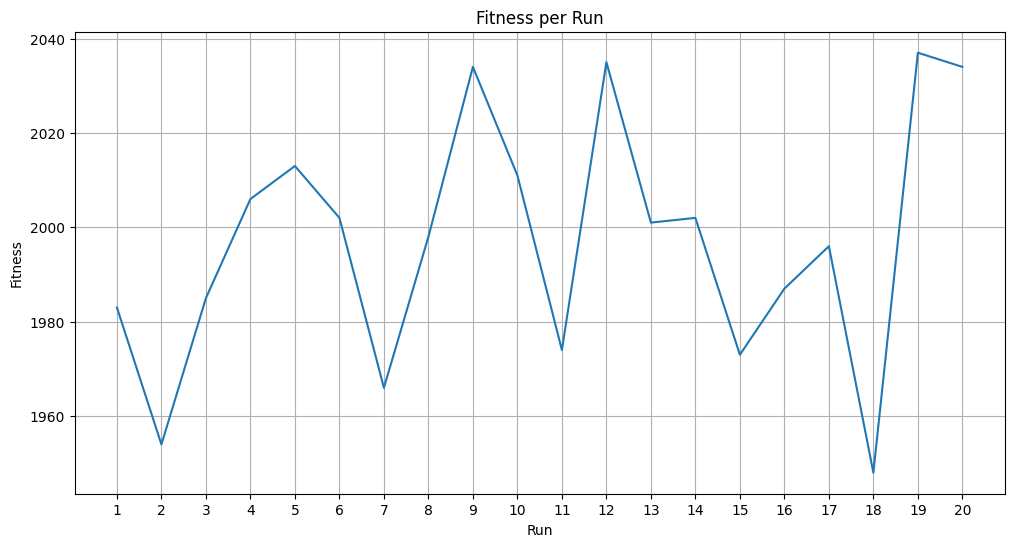

In [121]:
visualize(df, "Fitness")

In [122]:
report(df, "Fitness")

Average: 1996.95
Maximum: 2037.00
Minimum: 1948.00
Standard Deviation: 26.30


The results demonstrate that the algorithm finds high-quality solutions with relatively low variability between runs. The difference between the maximum and minimum fitness values is small compared to the overall fitness scale, indicating that even the least optimal solutions are close to the best one. This stability indicates that the chosen hyperparameters provide a good balance between exploration and exploitation.

### 3.2. Execution Time Analysis

In [123]:
df["Execution Time (s)"]

0     0.326487
1     0.291809
2     0.296202
3     0.288788
4     0.288642
5     0.294571
6     0.297491
7     0.378347
8     0.290970
9     0.310632
10    0.317239
11    0.311961
12    0.296798
13    0.290281
14    0.301809
15    0.302970
16    0.314122
17    0.299300
18    0.303370
19    0.300134
Name: Execution Time (s), dtype: float64

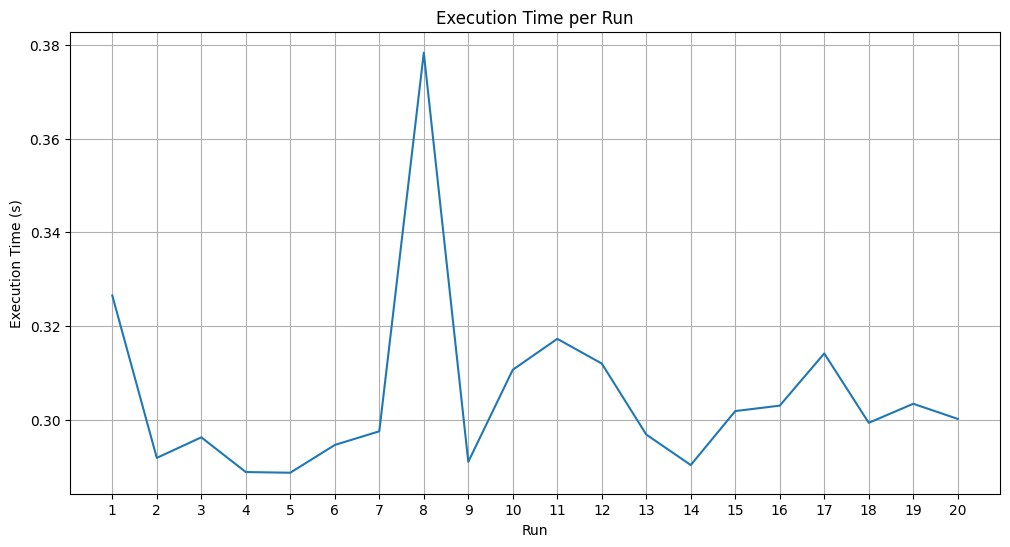

In [124]:
visualize(df, "Execution Time (s)")

In [125]:
report(df, "Execution Time (s)")

Average: 0.31
Maximum: 0.38
Minimum: 0.29
Standard Deviation: 0.02


The execution time is consistently low, indicating that the algorithm performs efficiently for the given problem instance and parameter configuration.
The small variation between the minimum and maximum times, along with a low standard deviation, shows that the runtime is highly stable across different executions, showing that the Genetic Algorithm achieves a good trade-off between solution quality and computational cost.

### 3.3. Memory Usage Analysis

In [126]:
df["Memory Usage (MiB)"]

0     276.078125
1     276.078125
2     276.078125
3     276.078125
4     276.078125
5     276.078125
6     276.078125
7     276.078125
8     276.078125
9     276.078125
10    276.078125
11    276.078125
12    276.078125
13    276.078125
14    276.078125
15    276.078125
16    276.078125
17    276.078125
18    276.078125
19    276.078125
Name: Memory Usage (MiB), dtype: float64

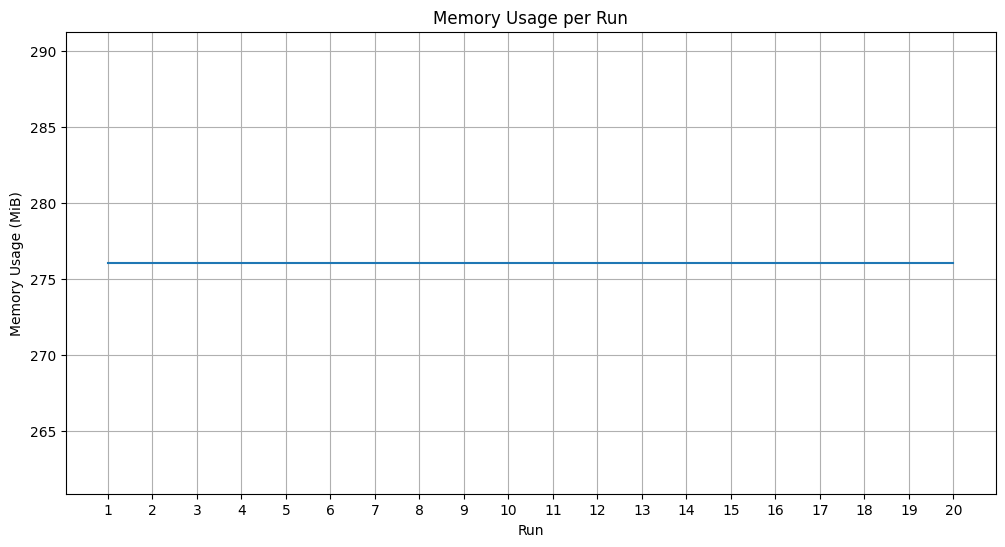

In [127]:
visualize(df, "Memory Usage (MiB)")

In [128]:
report(df, "Memory Usage (MiB)")

Average: 276.08
Maximum: 276.08
Minimum: 276.08
Standard Deviation: 0.00


The memory usage remained constant across all executions because the operating system allocates memory in fixed-size chunks (pages), and the `memory_usage` function measures memory at the process level rather than tracking every small allocation.